In [1]:
import cv2 as cv
import numpy as np
import os
import time
import matplotlib.pyplot as plt
from pathlib import Path


In [2]:
def display_image(window_name, img, window_1_name=None, img_1=None):
    """
    Displays image with given window name.
    :param window_name: name of the window
    :param img: image object to display
    """
    if window_1_name is not None and img_1 is not None:
        plt.figure(figsize=(20, 10))
        plt.subplot(1, 2, 1)
        plt.imshow(img, cmap="gray")
        plt.title(window_name)
        plt.subplot(1, 2, 2)
        plt.imshow(img_1, cmap="gray")
        plt.title(window_1_name)
    else:
        plt.imshow(img, cmap='gray')
        plt.title(window_name)
        plt.show()  

    
        

## Task 1 Fourier Transform
In this task, we will show a useful property of the Fourier
Transform, which is the convolution property. It tells us that convolution in the
spatial domain corresponds to multiplication in the frequency domain. The input
image that you will be operating on is orange.jpeg and celeb.jpeg.

* Load the two images orange.jpeg and celeb.jpeg. Remember to convert to
grayscale.

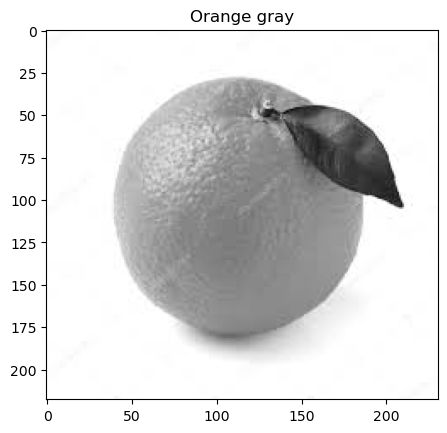

Orange shape: (218, 231)


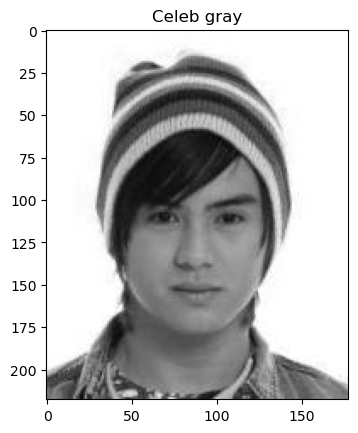

Celeb shape: (218, 178)


In [3]:
# set images pathes
orange_path = '../data/orange.jpeg'
celeb_path = '../data/celeb.jpeg'
# read imgs
img_orange = cv.imread(orange_path, cv.IMREAD_GRAYSCALE)
img_celeb = cv.imread(celeb_path, cv.IMREAD_GRAYSCALE)

display_image('Orange gray', img_orange)
print(f"Orange shape: {img_orange.shape}")
display_image('Celeb gray', img_celeb)
print(f"Celeb shape: {img_celeb.shape}")

* Create a 7 × 7 Gaussian kernel with sigma=1.

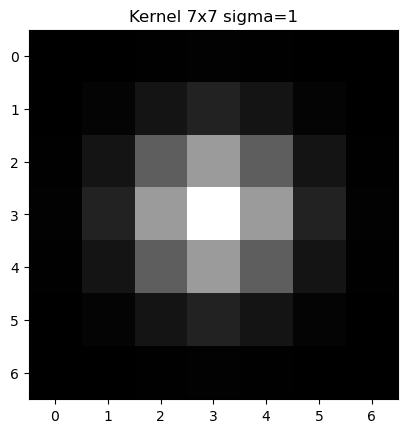

In [4]:

kernel_size = 7
kernel = kernel = cv.getGaussianKernel(kernel_size, 1)
kernel_2d = kernel * kernel.T

display_image('Kernel 7x7 sigma=1', kernel_2d)

In [5]:
def blur_im_spatial(image, kernel):
    """
    Blurs the image using spatial filtering.
    :param image: image to blur
    :param kernel: kernel to use for blurring
    :return: blurred image
    """
    return cv.filter2D(image,  -1, kernel=kernel_2d).astype(np.uint8)


* Blur the images by convolving the image with the Gaussian kernel directly in
the spatial domain. You may use the library function (cv2.filter2D).

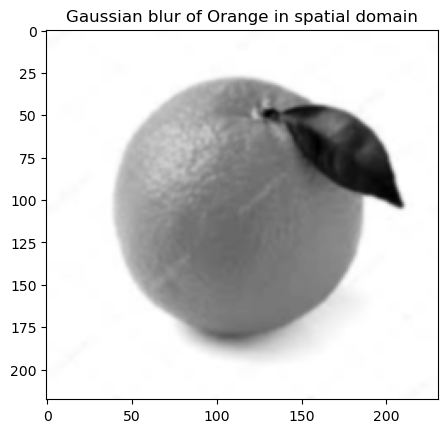

In [6]:
start = time.perf_counter()
blur_img_orange_spatial = blur_im_spatial(img_orange, kernel=kernel_2d)
end = time.perf_counter()
orange_spatial_time = end - start
display_image('Gaussian blur of Orange in spatial domain', blur_img_orange_spatial)

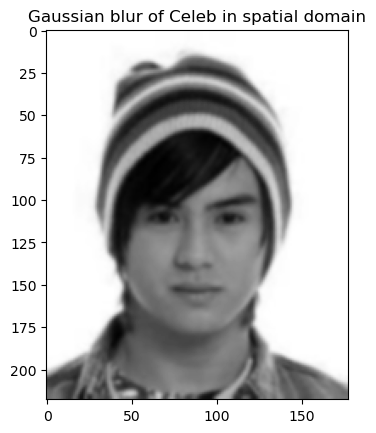

In [7]:
start = time.perf_counter()
blur_img_celeb_spatial = blur_im_spatial(img_celeb, kernel=kernel_2d)
end = time.perf_counter()
celeb_spatial_time = end - start
display_image('Gaussian blur of Celeb in spatial domain', blur_img_celeb_spatial)

* Now we are going to blur the images in the frequency domain using Fourier
Transform. We multiply the kernel function and the frequency image instead
of applying convolution. To get the final result, we transform back to the image
space. You may use functions included in the package numpy.fft to apply the
transform and its inverse.

In [8]:
# blur the image in the frequency domain
def blur_im_freq(image, kernel):
   
    # compute fft of image
    fft_image = np.fft.fft2(image)
    # compute fft of kernel with the same shape as image
    fft_kernel = np.fft.fft2(kernel, s=image.shape)
    fft_kernel_shift = np.fft.fftshift(fft_kernel)
    display_image('FFT of kernel', np.log(np.abs(fft_kernel_shift)))
    # compute convolution in frequency domain
    fft_result = fft_image * fft_kernel
    # compute inverse fft
    result = np.fft.ifft2(fft_result)
    # return real part of the result
    return np.abs(result).astype(np.uint8)

In [9]:
def blur_im_freq(image, kernel):
    """
    Blurs the image using frequency filtering.
    :param image: image to blur
    :param kernel: kernel to use for blurring
    :return: blurred image
    """
    image_height, image_width = image.shape
    kern_height, kern_width = kernel.shape
    # compute padding to make kernel shape equal to image shape
    padding_top = image_height // 2 - kern_height // 2
    padding_botton = image_height // 2 - kern_height // 2 - 1
    padding_left = image_width // 2 - kern_width // 2
    padding_right = image_width // 2 - kern_width // 2 - 1


    if(image_width % 2 == 1):
        padding_right += 1 
    # add padding to kernel
    padded_kernel = np.pad(
        kernel, pad_width=((padding_top, padding_botton), (padding_left, padding_right)),
        mode="constant", constant_values=0
    )

    # compute fft of image
    image_freq = np.fft.fft2(image)
    # compute fft of padded kernel 
    kernel_freq = np.fft.fft2(padded_kernel)
    # display_image('FFT of kernel', np.log(np.abs(kernel_freq)))
    # compute convolution in frequency domain
    fft_result_freq = image_freq * kernel_freq
    # compute inverse fft
    fft_result = np.fft.ifft2(fft_result_freq)

    # fixing the shift
    fft_result = np.fft.fftshift(fft_result)
    # return real part of the result
    fft_result = np.abs(fft_result).clip(min=0, max=255)  # clipping to [0, 255] because of numerical errors the max values are slightly above 255

    # ??? casting to uint8 is not needed because of clipping, but if I cast to uint8, it makes the difference between spatial and frequency domain higher ???
    # I dont understand Why

    return fft_result

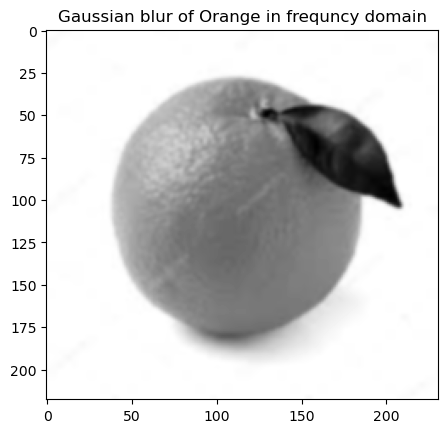

In [10]:
start = time.perf_counter()
blur_img_orange_frequency = blur_im_freq(img_orange, kernel=kernel_2d)
end = time.perf_counter()
orange_freq_time = end - start
display_image('Gaussian blur of Orange in frequncy domain', blur_img_orange_frequency)

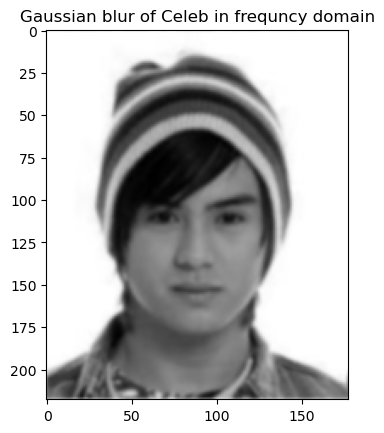

In [11]:
start = time.perf_counter()
blur_img_celeb_frequency = blur_im_freq(img_celeb, kernel=kernel_2d)
end = time.perf_counter()
celeb_freq_time = end - start
display_image('Gaussian blur of Celeb in frequncy domain', blur_img_celeb_frequency)

* Visualise the results for both images and report the mean absolute difference
between the two blurring methods and the time taken by each of them.

In [12]:
def difference_between(im_1,im_2):
    """
    Computes the absolute difference and
    mean absolute difference between two images.
    """
    diff = np.abs(np.subtract(im_1, im_2))
    mean_diff = np.mean(diff)
    return diff, mean_diff

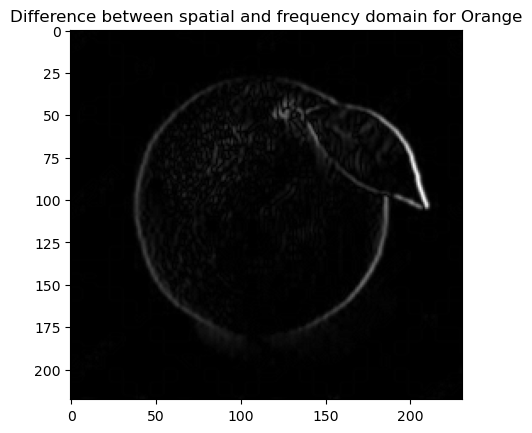

Orange mean difference: 1.3574241639103943


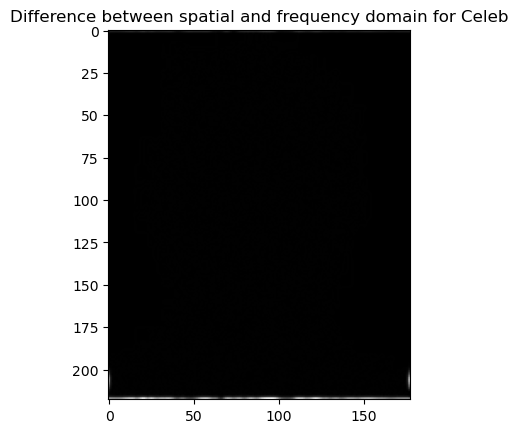

Celeb mean difference: 1.3574241639103943

Orange spatial time: 0.005595999999997048
Orange frequency time: 0.013707999999994058
Celeb spatial time: 0.00043569999999704123
Celeb frequency time: 0.01497940000000142


In [13]:
orange_diff, orange_mean_diff = difference_between(blur_img_orange_spatial, blur_img_orange_frequency)
celeb_diff, celeb_mean_diff = difference_between(blur_img_celeb_spatial, blur_img_celeb_frequency)

display_image('Difference between spatial and frequency domain for Orange', orange_diff)
print(f"Orange mean difference: {orange_mean_diff}")
display_image('Difference between spatial and frequency domain for Celeb', celeb_diff)
print(f"Celeb mean difference: {orange_mean_diff}")
print()

print(f"Orange spatial time: {orange_spatial_time}")
print(f"Orange frequency time: {orange_freq_time}")

print(f"Celeb spatial time: {celeb_spatial_time}")
print(f"Celeb frequency time: {celeb_freq_time}")


## Template Matching    
In this task, we will implement template matching using Sum
Square Difference and normalized cross-correlation similarity measures. The input
image is RidingBike.jpeg and the template image (what we want to find in the
larger input image) is RidingBikeTemplate.jpeg

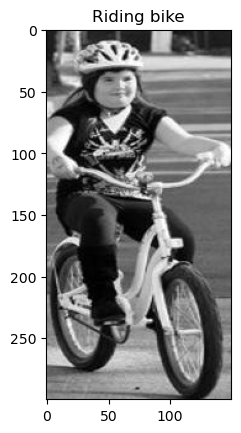

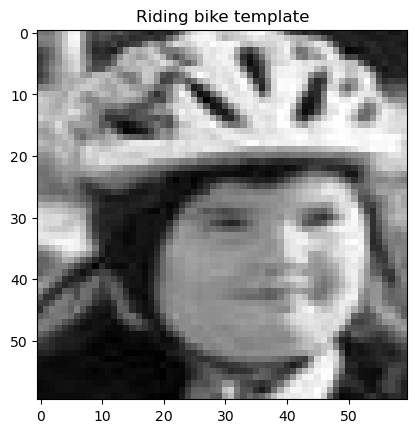

In [14]:
# set images pathes
riding_bike_path = '../data/ridingBike.jpeg'
riding_bike_template_path = '../data/ridingBikeTemplate.jpeg'
# read imgs
riding_bike = cv.imread(riding_bike_path, cv.IMREAD_GRAYSCALE)
riding_bike_template = cv.imread(riding_bike_template_path, cv.IMREAD_GRAYSCALE)

display_image('Riding bike', riding_bike)
display_image('Riding bike template', riding_bike_template)

* Implement Sum Square Difference.

$$
h[n, m] = \sum_{k,l}^{}(g[k,l] - f[m+k, n+l])^2
$$

In [15]:
def sum_squared_diff(im_1, im_2):
    """
    Computes the sum of squared differences between two images.
    """
    return np.sum(np.square(np.subtract(im_2, im_1)))

* Implement template matching using your implementation of Sum Square Difference.

In [16]:
def templ_matching_ssd(image, template):
    """
    Computes the sum of squared differences between the template and every possible location in the image.
    :param im: image to search in
    :param template: template to search for
    :return: image with the sum of squared differences
    """
    image_h, image_w = image.shape
    template_h, template_w = template.shape

    result = np.zeros(
        (image_h - template_h + 1, image_w - template_w + 1), dtype=np.float32
    )
    for i in range(result.shape[0]):
        for j in range(result.shape[1]):
            result[i, j] = sum_squared_diff(
                image[i : i + template_h, j : j + template_w], template
            )

    return result

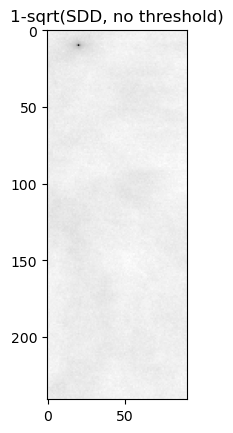

In [17]:
similarity_ssd_img = templ_matching_ssd(riding_bike, riding_bike_template)
similarity_ssd_img = similarity_ssd_img / similarity_ssd_img.max()
display_image('1-sqrt(SDD, no threshold)', similarity_ssd_img)

## for some reason detection is shown with lower values

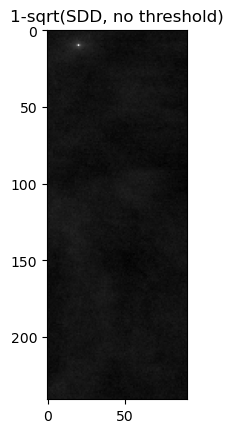

In [18]:
## I will use 1 - similarity_ssd_img to get the same result as in the lecture

similarity_ssd_img = 1 - similarity_ssd_img
display_image('1-sqrt(SDD, no threshold)', similarity_ssd_img)

* Implement Normalized Cross-correlation.

$$
h[n, m] = \frac{\sum_{k,l}^{}(g[k,l] - \bar{g})- (f[m+k, n+l] - \bar{f_{m,n}})}{\left(\sum_{k,l}^{}(g[k,l] - \bar{g})^2 \sum_{k,l}^{}(f[m+k, n+l] - \bar{f_{m,n}})^2\right)^{0.5}}
$$

In [19]:
def normalized_cross_correlation(im_1, im_2):
    """
    Computes the normalized cross correlation between two images.
    """
    im_1_mean = np.mean(im_1)
    im_2_mean = np.mean(im_2)

    norm = np.sqrt(
                np.sum(np.power(im_2 - im_2_mean, 2))
                * np.sum(np.power(im_1 - im_2_mean, 2))
            )

    return np.sum(np.multiply(im_2 - im_2_mean, im_1 - im_1_mean)) / norm
    

* Implement template matching using Normalized Cross-correlation.

In [20]:
def templ_matching_nxc(image, template):
    """
    Computes the normalized cross correlation between the template and every possible location in the image.
    :param image: image to search in
    :param template: template to search for
    :return: image with the normalized cross correlation
    """
    image_h, image_w = image.shape
    template_h, template_w = template.shape

    result = np.zeros(
        (image_h - template_h + 1, image_w - template_w + 1), dtype=np.float32
    )
    for i in range(result.shape[0]):
        for j in range(result.shape[1]):
            result[i, j] = normalized_cross_correlation(
                image[i : i + template_h, j : j + template_w], template
            )

    return result

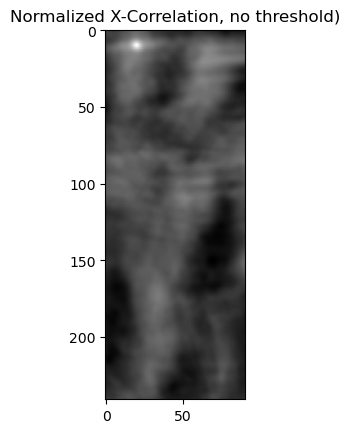

In [21]:
similarity_nxc_img = templ_matching_nxc(riding_bike, riding_bike_template)
similarity_nxc_img = similarity_nxc_img - similarity_nxc_img.min()
similarity_nxc_img = similarity_nxc_img / similarity_nxc_img.max()
display_image('Normalized X-Correlation, no threshold)', similarity_nxc_img)

* Draw rectangles on the image where similarity ≥ 0.5 for both methods. You
may experiment with other threshold values to determine the matching.

In [22]:
def draw_rectangle_at_detection(image, template_shape, detection_positions):
    detection_positions = zip(detection_positions[0], detection_positions[1])
    for detection_position in detection_positions:
        cv.rectangle(
            image,
            (detection_position[1], detection_position[0]),
            (detection_position[1] + template_shape[1], detection_position[0] + template_shape[0]),
            0
        )
    return image

(array([10], dtype=int64), array([20], dtype=int64))


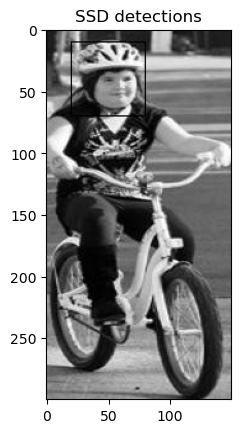

In [23]:
threshold = 0.5
detections = np.where(similarity_ssd_img >= threshold)
print(detections)
result = draw_rectangle_at_detection(riding_bike.copy(), riding_bike_template.shape, detections)

display_image('SSD detections', result)

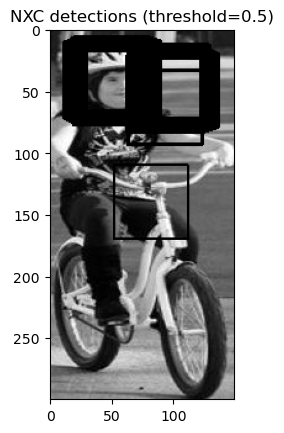

In [24]:
threshold = 0.5
detections = np.where(similarity_nxc_img >= threshold)
result = draw_rectangle_at_detection(riding_bike.copy(), riding_bike_template.shape, detections)

display_image('NXC detections (threshold=0.5)', result)

ok, too many false positive detections
lets make threshold higher

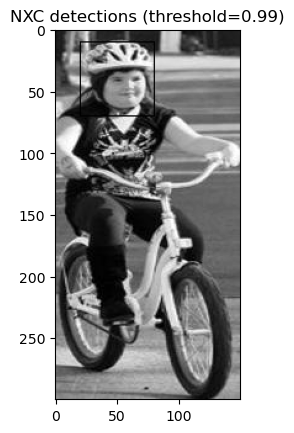

In [25]:
threshold = 0.99
detections = np.where(similarity_nxc_img >= threshold)
result = draw_rectangle_at_detection(riding_bike.copy(), riding_bike_template.shape, detections)

display_image(f'NXC detections (threshold={threshold})', result)

## Template matching multi-scale

In this task, we will build the Gaussian pyramid to make template matching work at different resolutions. 
Read the image DogGray.jpeg and the template DogTemplate.jpeg

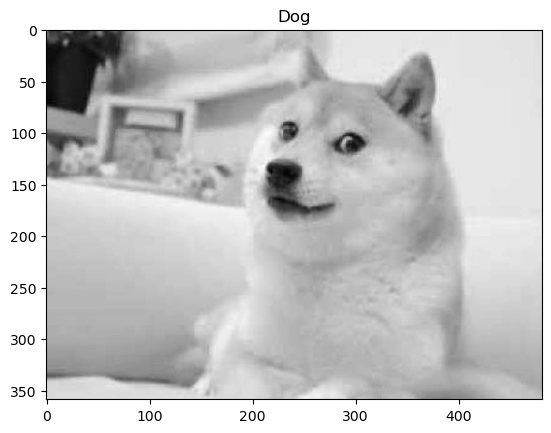

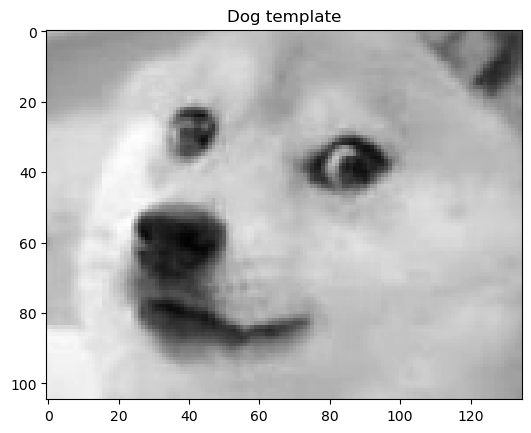

In [26]:
# set images pathes
dog_path = '../data/DogGray.jpeg'
dog_template_path = '../data/DogTemplate.jpeg'
# read imgs
dog = cv.imread(dog_path, cv.IMREAD_GRAYSCALE)
dog_template = cv.imread(dog_template_path, cv.IMREAD_GRAYSCALE)

display_image('Dog', dog)
display_image('Dog template', dog_template)

* Build a 5 level Gaussian pyramid by downsampling input image yourself.

In [27]:
def build_gaussian_pyramid(image, num_levels):
    """
    Builds a Gaussian pyramid of an image.
    :param image: image to build the pyramid from
    :param num_levels: number of levels in the pyramid
    :return: Gaussian pyramid
    """
    pyramid = [image]
    for i in range(num_levels - 1):
        # pyramid.append(cv.pyrDown(pyramid[i]))
        blurred_image = cv.GaussianBlur(src=image, ksize=(0, 0), sigmaX=1)
        image = blurred_image[0::2, 0::2] # downsampling by 2 (even rows and columns)
        pyramid.append(image)
    return pyramid

    

* Now create a 5 level Gaussian pyramid using cv2.pyrDown. Compare it with
your implementation by printing the mean absolute difference at each level.

In [28]:
def build_gaussian_pyramid_opencv(image, num_levels):
    pyramid = [image]
    for i in range(num_levels - 1):
        pyramid.append(cv.pyrDown(pyramid[i])) 
    return pyramid

Mean absolute difference between the two images (lavel 0): 0.0
Mean absolute difference between the two images (lavel 1): 3.4180267404333793
Mean absolute difference between the two images (lavel 2): 7.099173553719008
Mean absolute difference between the two images (lavel 3): 11.850273224043717
Mean absolute difference between the two images (lavel 4): 26.189340813464234


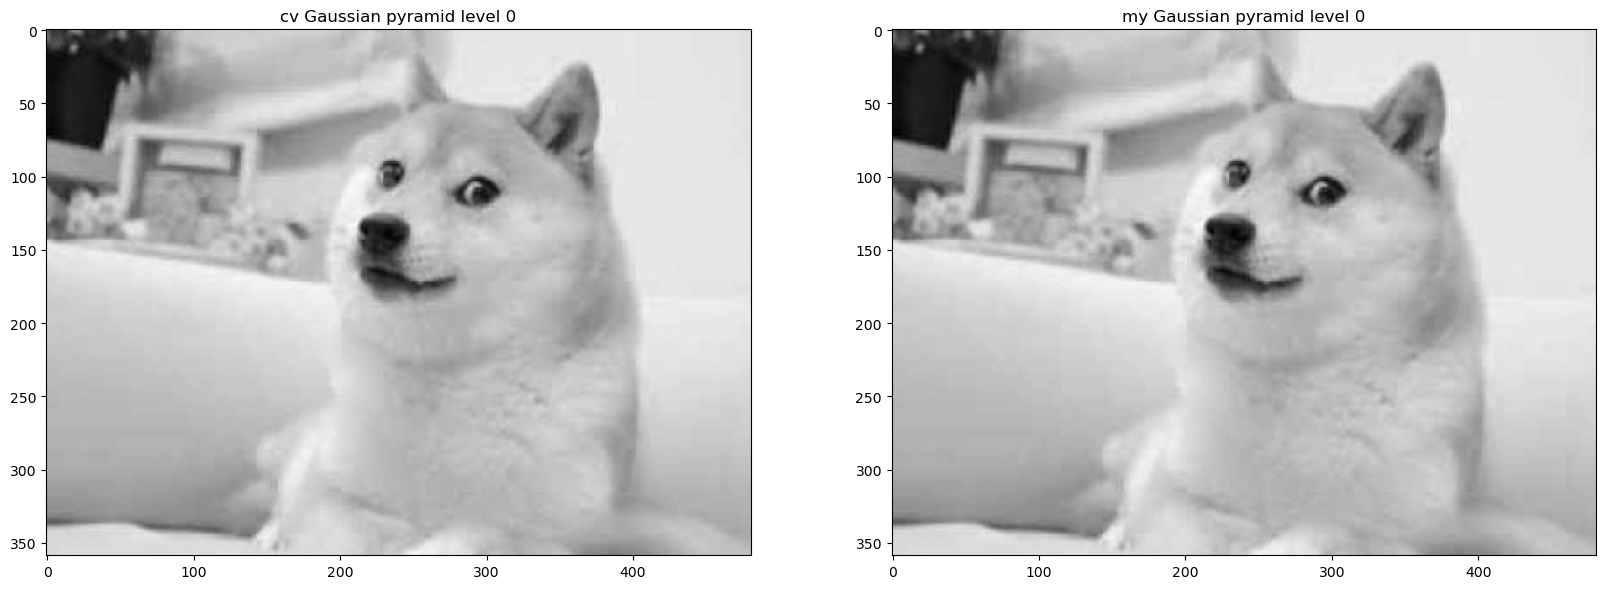

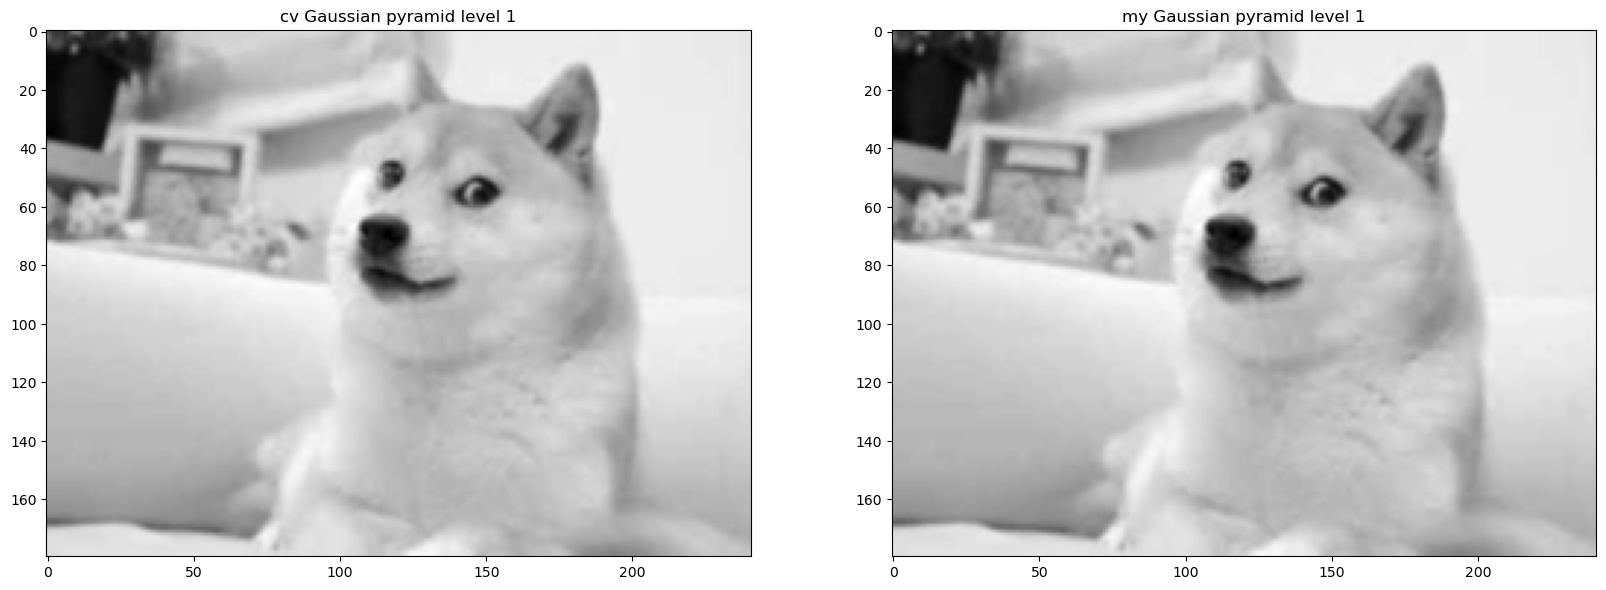

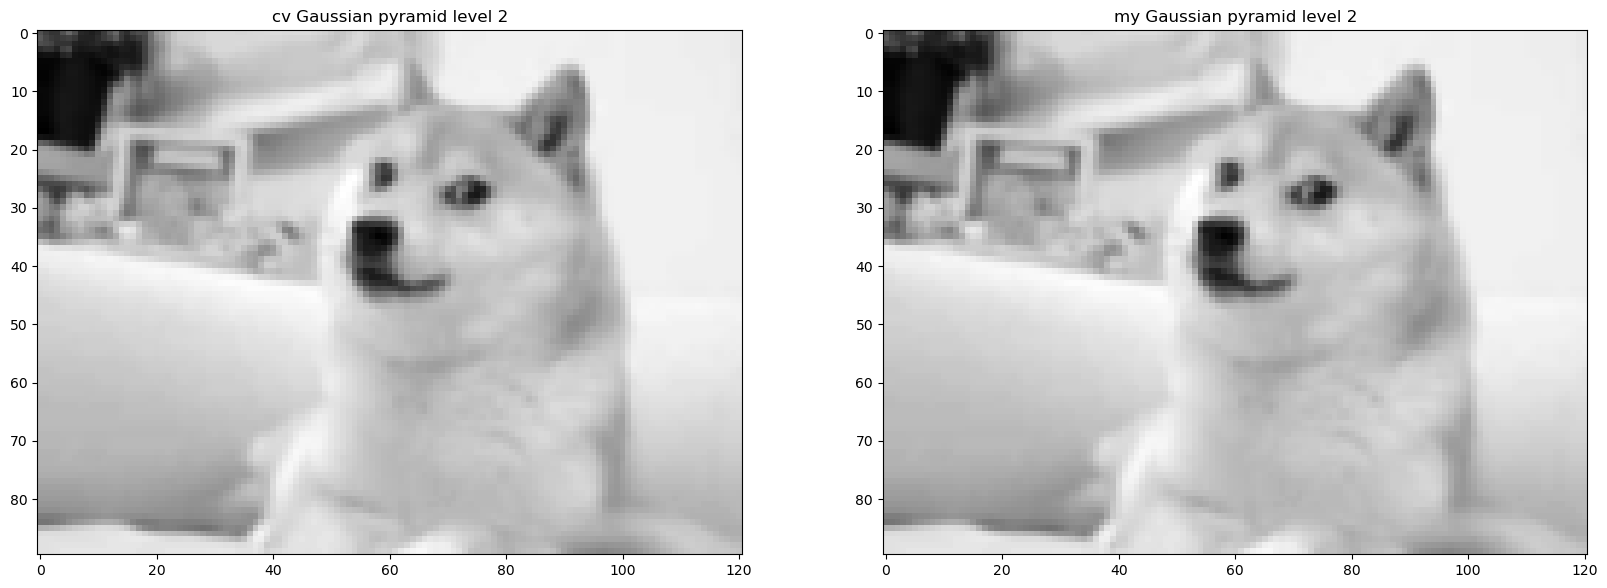

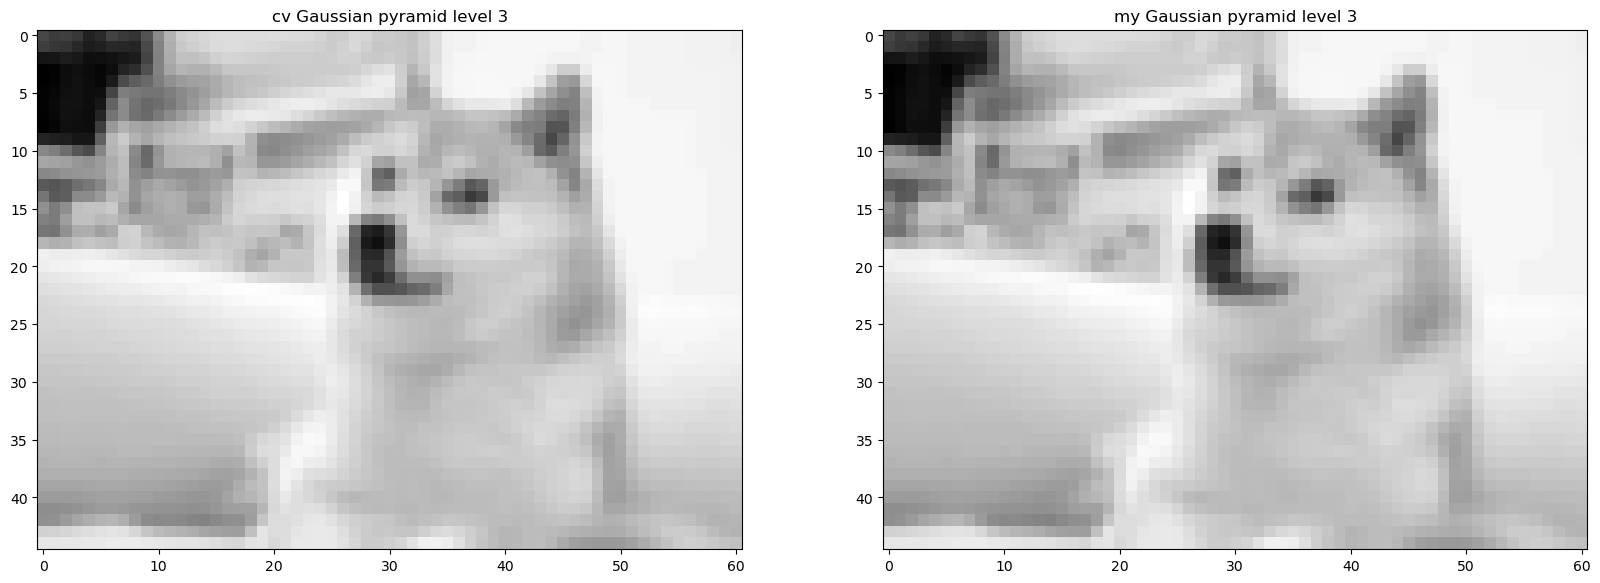

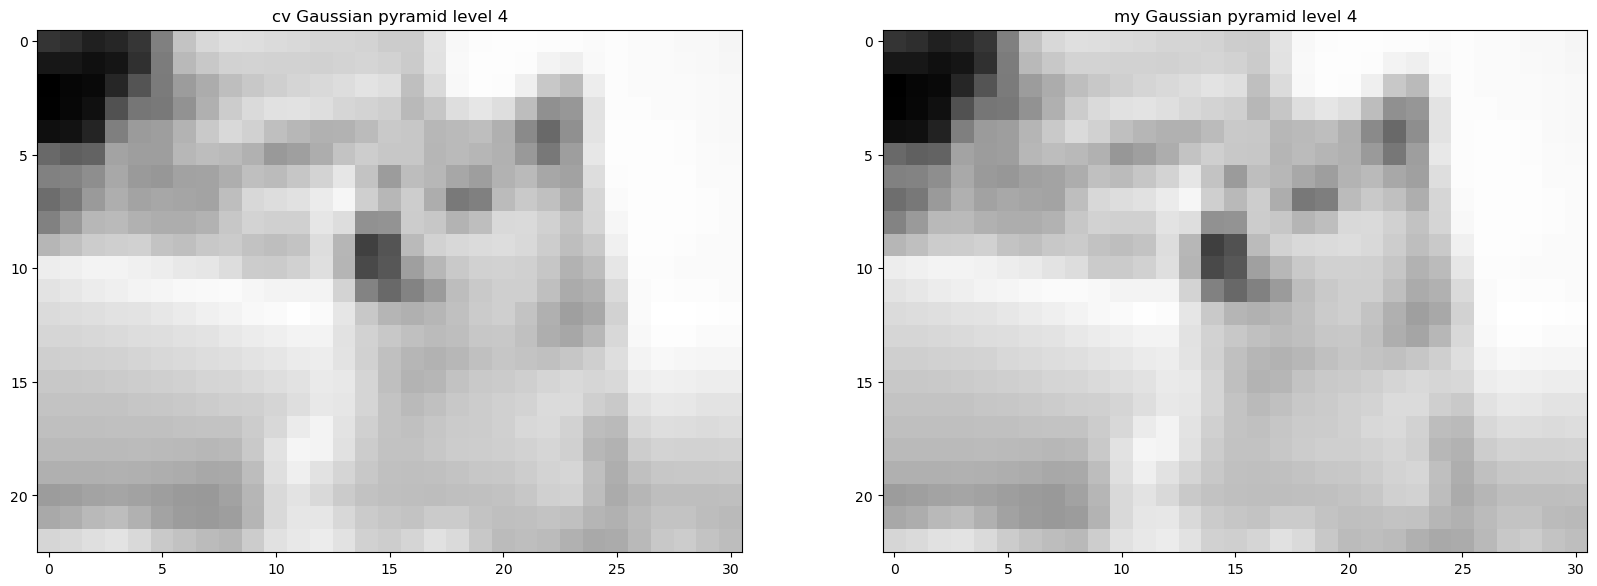

In [29]:
pyramid_my = build_gaussian_pyramid(dog, 5)
pyramid_cv = build_gaussian_pyramid_opencv(dog, 5)
for i, images in enumerate(zip(pyramid_cv, pyramid_my)):
    display_image(f'cv Gaussian pyramid level {i}', images[0], f'my Gaussian pyramid level {i}', images[1]) 
    print(f"Mean absolute difference between the two images (lavel {i}): {np.mean(np.abs(images[0] - images[1]))}")

* Perform template matching by using your implementation of normalized cross
correlation . Report the time taken by this method.

Time for NXC: 83.8887624 seconds


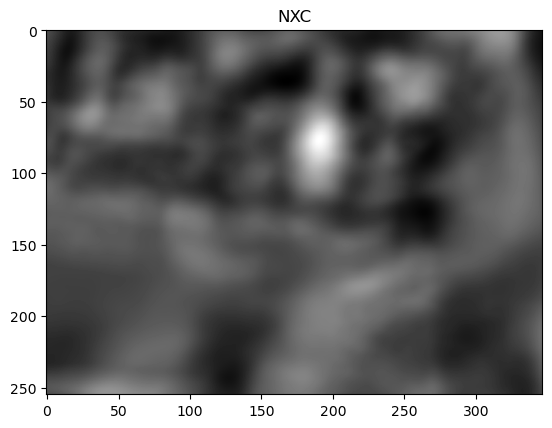

In [30]:
start = time.perf_counter()
similarity_nxc_img_ = templ_matching_nxc(dog, dog_template)
end = time.perf_counter()
print(f"Time for NXC: {end - start} seconds")
display_image('NXC', similarity_nxc_img_)

0.6138081


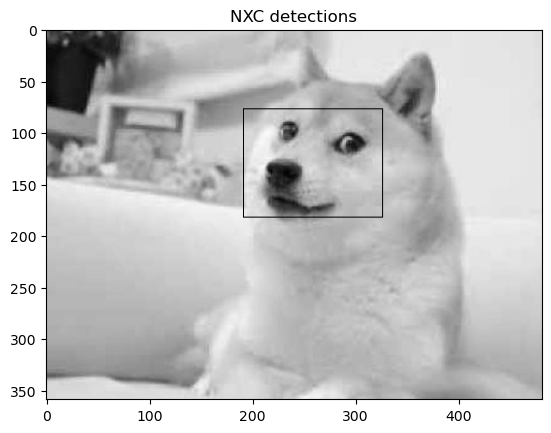

In [31]:
detections = np.where(similarity_nxc_img_ >= 0.613)
print(similarity_nxc_img_.max(  ))
result = draw_rectangle_at_detection(dog, dog_template.shape, detections)
display_image('NXC detections', result)

* Show the template matching using normalized cross correlation at the different
Pyramid levels of both the template and input images (you can use the pyramid
obtained by pyrDown).

0.6138081
Time for NXC image in level 0: 0.027055199999949764 seconds
0.39647225
Time for NXC image in level 1: 6.741248499999983 seconds
0.36123076
Time for NXC image in level 2: 0.7122933000000558 seconds
0.29898095
Time for NXC image in level 3: 0.11704840000015793 seconds
0.3208139
Time for NXC image in level 4: 0.027118499999915002 seconds


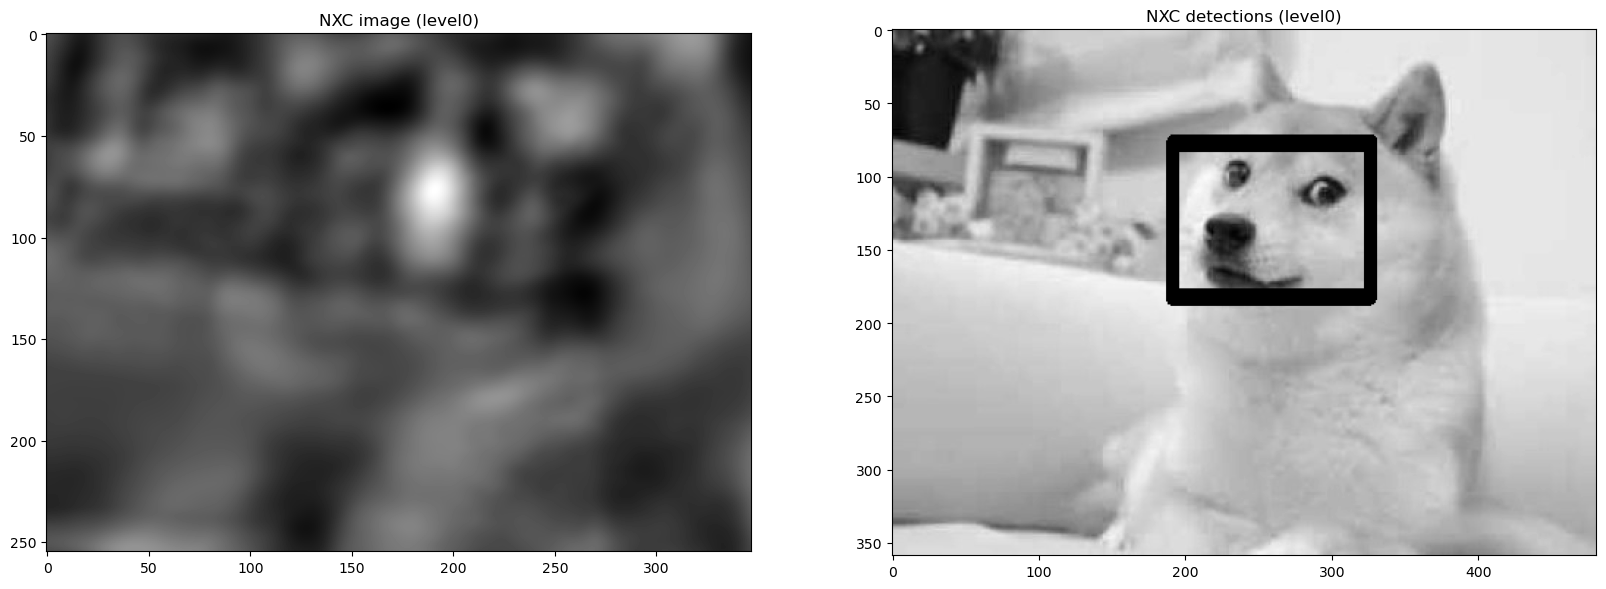

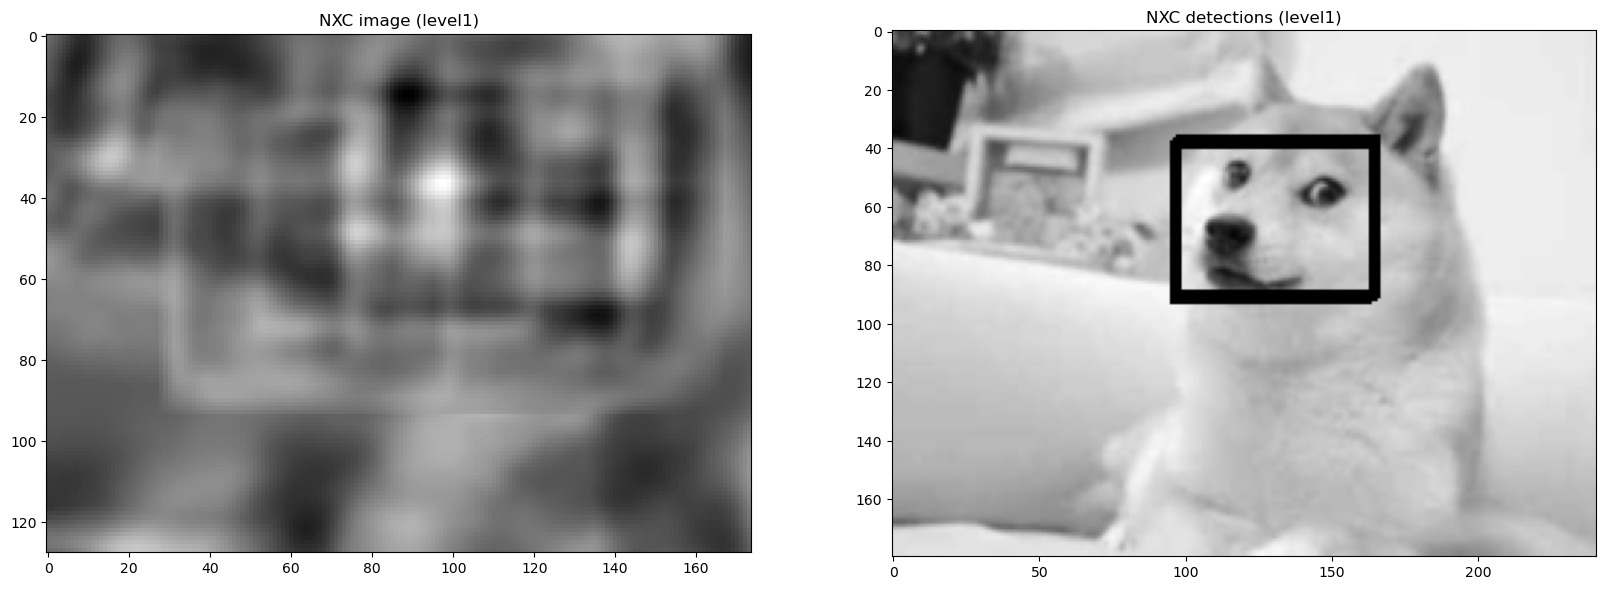

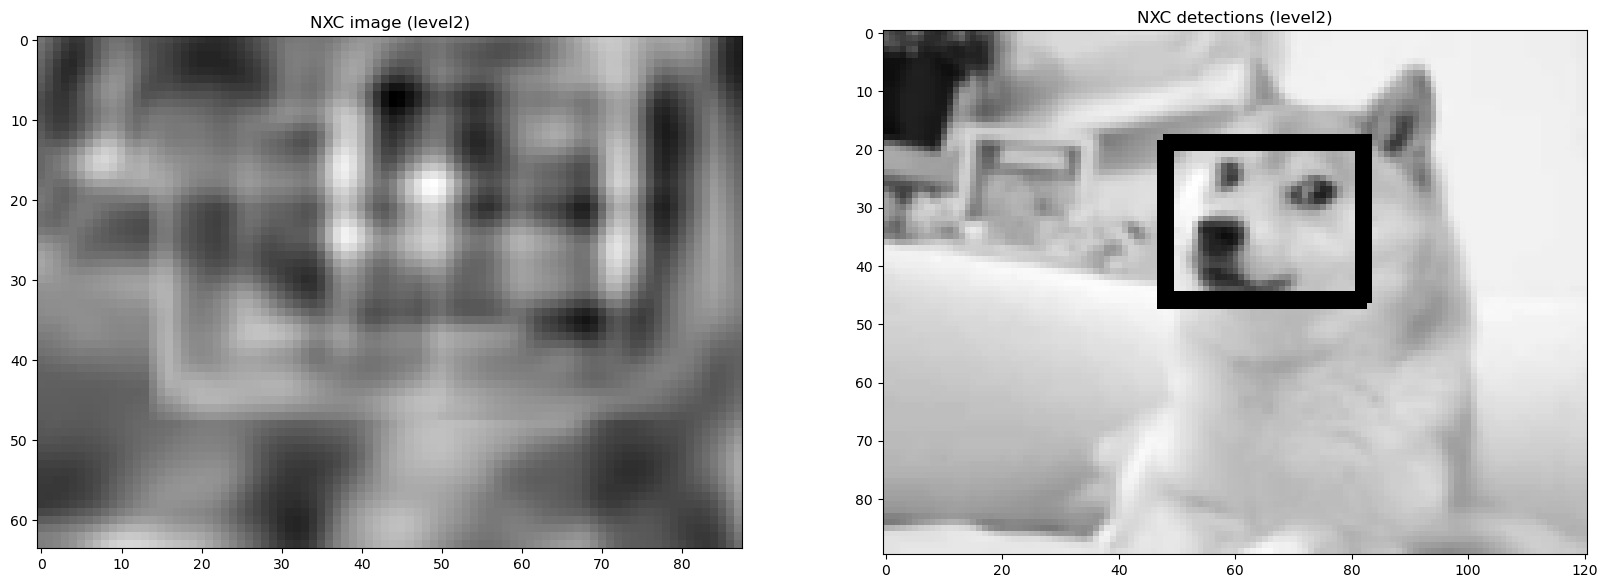

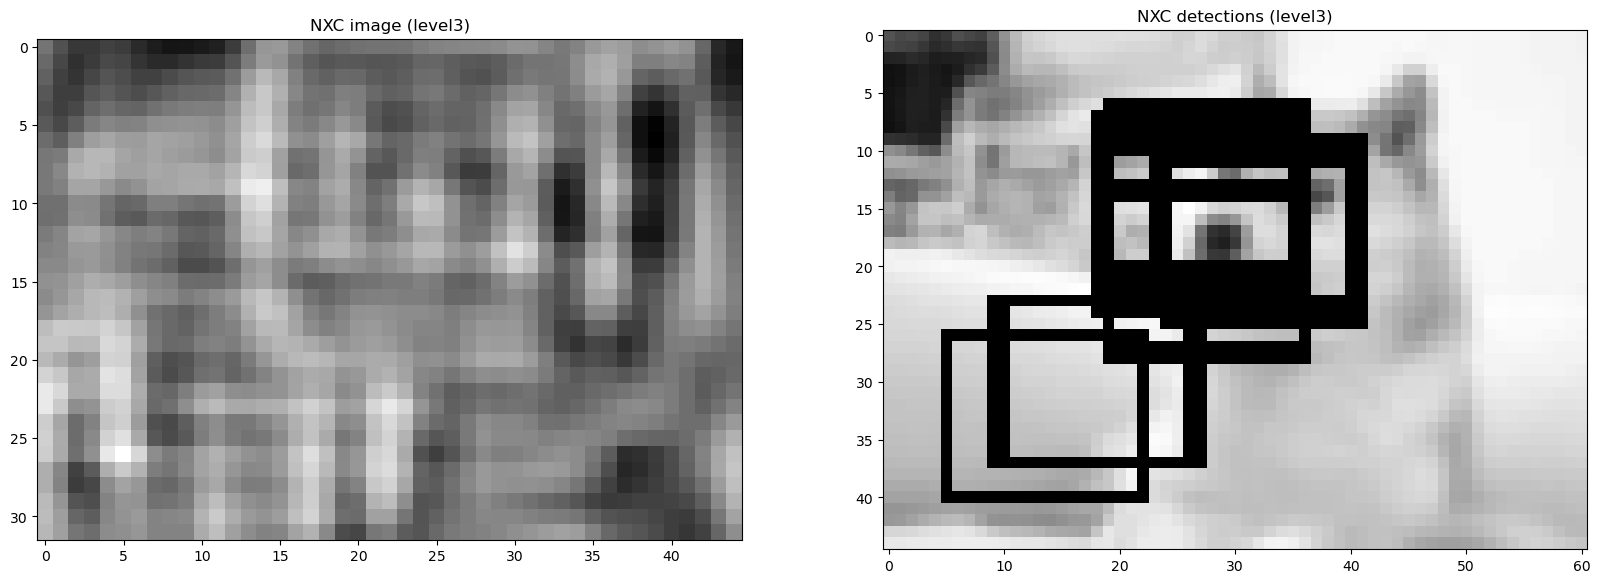

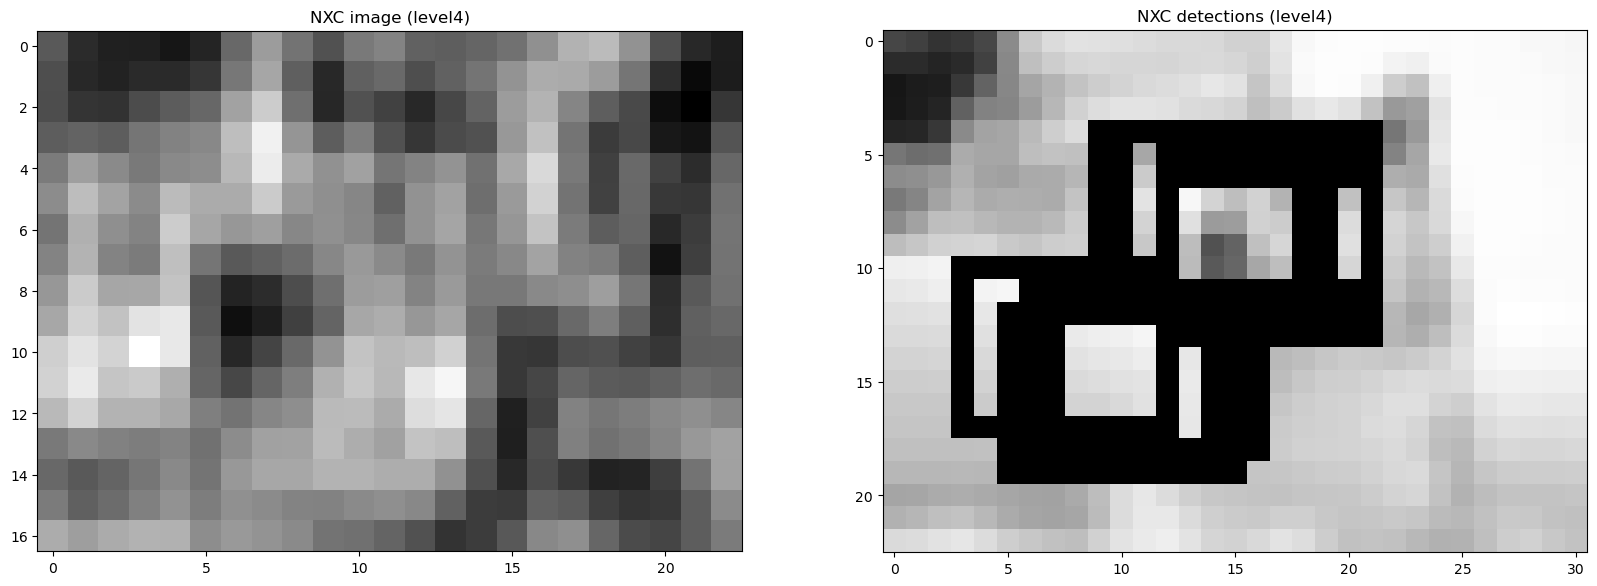

In [44]:
# pyramid_cv
pyramid_tmpl_cv = build_gaussian_pyramid_opencv(dog_template, 5)

similarity_nxc_img_arr = [similarity_nxc_img_]
time_arr = [end - start]
for i in range(1, len(pyramid_cv)):
    start = time.perf_counter()
    similarity_nxc_img_arr.append(templ_matching_nxc(pyramid_cv[i], pyramid_tmpl_cv[i]))
    end = time.perf_counter()
    time_arr.append(end - start)

for i, simil_image in enumerate(similarity_nxc_img_arr):
    detections = np.where(simil_image >= simil_image.max( ) - 0.003)
    print(simil_image.max( ))
    result_ = draw_rectangle_at_detection(pyramid_cv[i], pyramid_tmpl_cv[i].shape, detections)
    display_image(f'NXC image (level{i})', simil_image, f'NXC detections (level{i})', result_)
    print(f"Time for NXC image in level {i}: {time_arr[i]} seconds")

* As you observed, implementing template matching naively is not efficient. Now
we will rely on the pyramid technique while constraining the search space in
order to make it faster. Follow the procedure described in the lecture slides:
search only in regions with high similarity in the previous pyramid level. Compare
the times taken by this method and the naive implementation.

In [ ]:
def template_matching_multiple_scales(pyramid_image, pyramid_template):
    """
    Performs template matching on multiple scales.
    :param pyramid_image: image pyramid
    :param pyramid_template: template pyramid
    :return: similarity map
    """

    # reverse pyramid_image and pyramid_template
    pyramid_image = pyramid_image[::-1]
    pyramid_template = pyramid_template[::-1]


    similarity_img = templ_matching_nxc(pyramid_image[0], pyramid_template[0])
    for i in range(1, len(pyramid_image)):
        similarity_img += templ_matching_nxc(pyramid_image[i], pyramid_template[i])
    return similarity_img
